In [32]:
# !pip install pandas numpy matplotlib seaborn scipy python-dotenv

In [33]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import warnings
from scipy.ndimage import gaussian_filter1d
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [34]:
from dotenv import load_dotenv
load_dotenv()

POSTGRES_USER = os.getenv('POSTGRES_USER')
POSTGRES_PASSWORD = os.getenv('POSTGRES_PASSWORD')
POSTGRES_DB = os.getenv('POSTGRES_DB')
POSTGRES_PORT = os.getenv('POSTGRES_PORT')

In [35]:
def get_db_connection():
    conn = psycopg2.connect(
        host="87.242.101.90",
        database='md_ticket',
        user='md_ticket_user',
        password='KYyo08n8AevLh',
        port=5432
    )
    return conn

try:
    conn = get_db_connection()
    print("✅ Успешное подключение к базе данных!")
    conn.close()
except Exception as e:
    print(f"❌ Ошибка подключения: {e}")

✅ Успешное подключение к базе данных!


In [36]:
def analyze_monthly_prices():
    """Анализ цен по месяцам вылета"""
    conn = get_db_connection()
    query = """
    SELECT
        departure_month,
        EXTRACT(MONTH FROM departure_month) as month_num,
        EXTRACT(YEAR FROM departure_month) as year,
        COUNT(*) as ticket_count,
        AVG(price_rub) as avg_price,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY price_rub) as median_price,
        MIN(price_rub) as min_price,
        MAX(price_rub) as max_price,
        STDDEV(price_rub) as price_stddev
    FROM dm.dm_fact_ticket_offers
    WHERE departure_month IS NOT NULL
    GROUP BY departure_month, EXTRACT(MONTH FROM departure_month), EXTRACT(YEAR FROM departure_month)
    ORDER BY departure_month
    """

    df_monthly = pd.read_sql(query, conn)
    conn.close()
    return df_monthly

monthly_prices = analyze_monthly_prices()
print("📊 Анализ цен по месяцам:")
print(monthly_prices.head())

📊 Анализ цен по месяцам:
  departure_month  month_num    year  ticket_count    avg_price  median_price  min_price  max_price  price_stddev
0      2025-12-01       12.0  2025.0         84335  9432.587822        8989.0       1257      27224   4450.811440
1      2026-01-01        1.0  2026.0         87310  6025.164460        5031.0       1286      27330   3822.391750
2      2026-02-01        2.0  2026.0         43517  4690.975136        4262.0       1381      13129   2110.258802
3      2026-03-01        3.0  2026.0         40297  4905.774077        4347.0       1655      14212   2232.695139
4      2026-04-01        4.0  2026.0         24744  6815.015438        6486.5       2269      17819   2575.135614


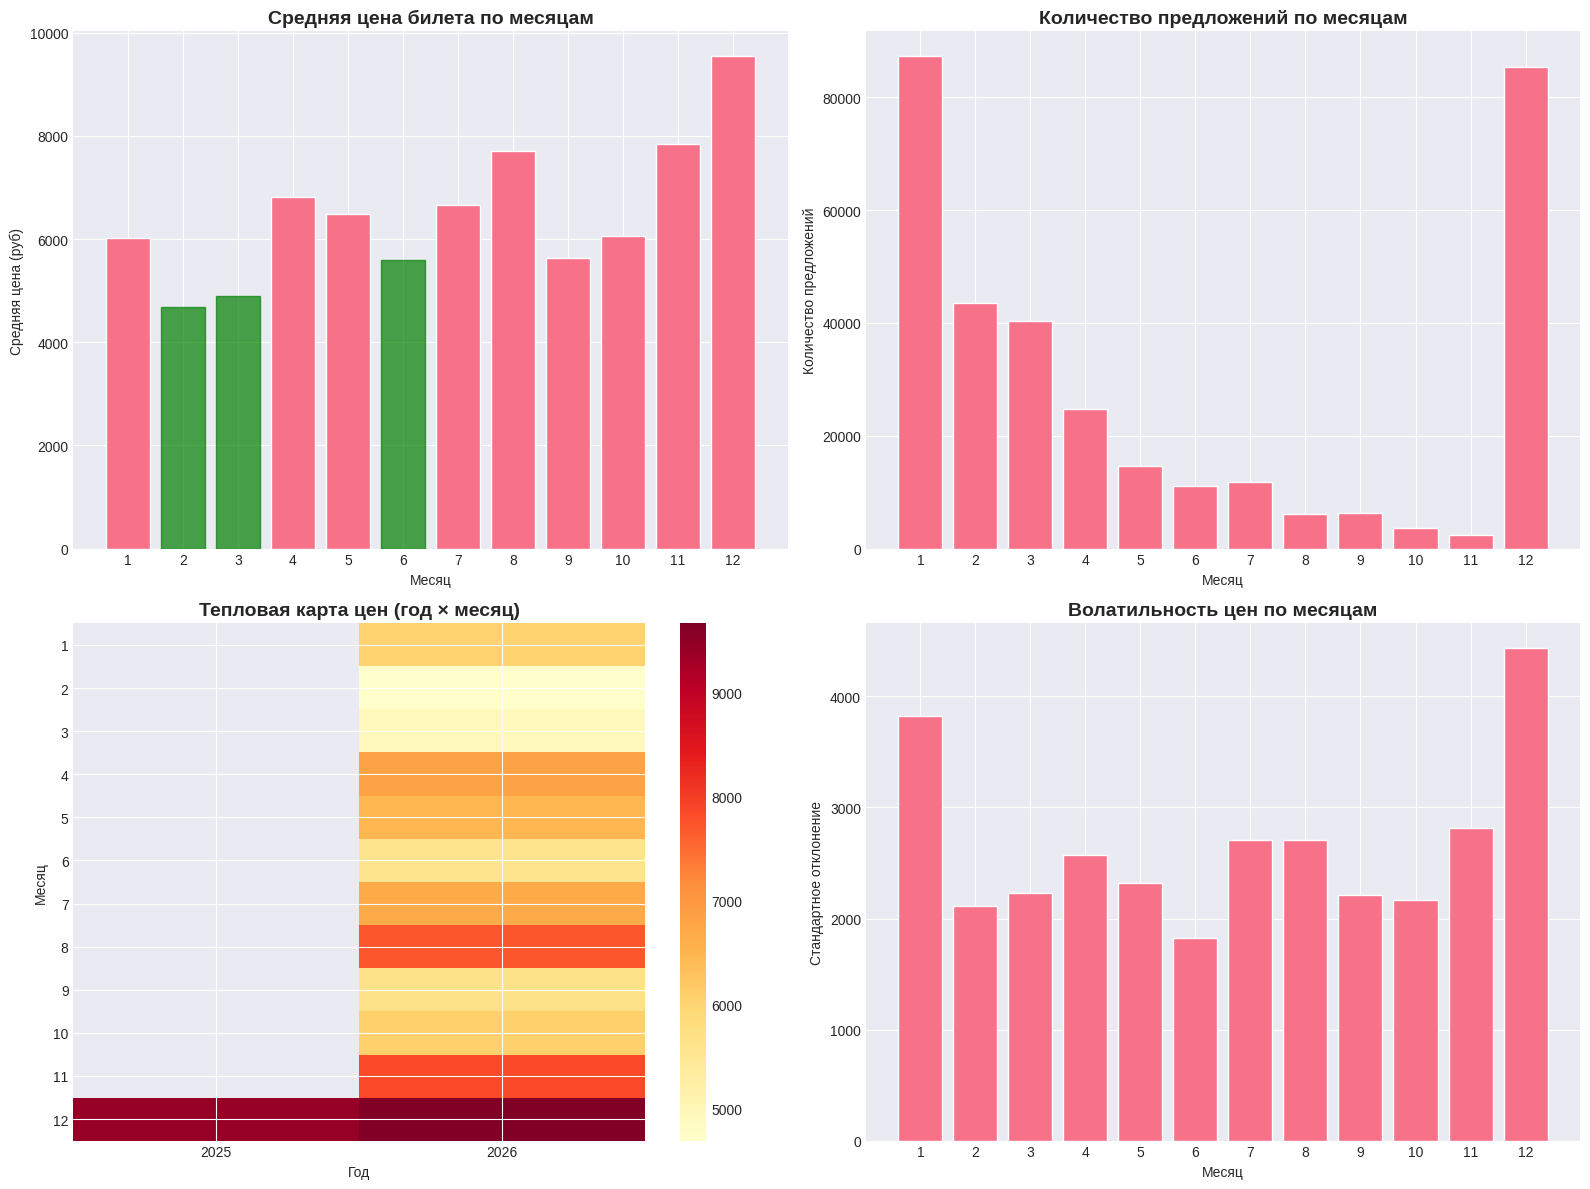


🎯 КЛЮЧЕВЫЕ ИНСАЙТЫ ПО МЕСЯЦАМ:
1. Самые дешевые месяцы для покупки: 2.0, 3.0, 6.0
2. Самый дорогой месяц: 12.0 (средняя цена: 9,550 руб)
3. Разница между самым дорогим и дешевым месяцем: 4,859 руб


In [37]:
def plot_monthly_prices(df):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Средняя цена по месяцам
    ax1 = axes[0, 0]
    monthly_avg = df.groupby('month_num')['avg_price'].mean()
    bars = ax1.bar(monthly_avg.index, monthly_avg.values)
    ax1.set_title('Средняя цена билета по месяцам', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Месяц')
    ax1.set_ylabel('Средняя цена (руб)')
    ax1.set_xticks(range(1, 13))

    # Подсветка самых дешевых месяцев
    min_months = monthly_avg.nsmallest(3).index
    for i, bar in enumerate(bars):
        if i+1 in min_months:
            bar.set_color('green')
            bar.set_alpha(0.7)

    # 2. Количество предложений по месяцам
    ax2 = axes[0, 1]
    monthly_count = df.groupby('month_num')['ticket_count'].sum()
    ax2.bar(monthly_count.index, monthly_count.values)
    ax2.set_title('Количество предложений по месяцам', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Месяц')
    ax2.set_ylabel('Количество предложений')
    ax2.set_xticks(range(1, 13))

    # 3. Цены по годам и месяцам (тепловая карта)
    ax3 = axes[1, 0]
    pivot_table = df.pivot_table(
        values='avg_price',
        index='month_num',
        columns='year',
        aggfunc='mean'
    )
    im = ax3.imshow(pivot_table.values, aspect='auto', cmap='YlOrRd')
    ax3.set_title('Тепловая карта цен (год × месяц)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Год')
    ax3.set_ylabel('Месяц')
    ax3.set_xticks(range(len(pivot_table.columns)))
    ax3.set_xticklabels([int(year) for year in pivot_table.columns])
    ax3.set_yticks(range(len(pivot_table.index)))
    ax3.set_yticklabels([int(month) for month in pivot_table.index])
    plt.colorbar(im, ax=ax3)

    # 4. Волатильность цен по месяцам
    ax4 = axes[1, 1]
    monthly_volatility = df.groupby('month_num')['price_stddev'].mean()
    ax4.bar(monthly_volatility.index, monthly_volatility.values)
    ax4.set_title('Волатильность цен по месяцам', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Месяц')
    ax4.set_ylabel('Стандартное отклонение')
    ax4.set_xticks(range(1, 13))

    plt.tight_layout()
    plt.show()

    # Вывод инсайтов
    print("\n🎯 КЛЮЧЕВЫЕ ИНСАЙТЫ ПО МЕСЯЦАМ:")
    print(f"1. Самые дешевые месяцы для покупки: {', '.join([str(m) for m in min_months])}")
    print(f"2. Самый дорогой месяц: {monthly_avg.idxmax()} (средняя цена: {monthly_avg.max():,.0f} руб)")
    print(f"3. Разница между самым дорогим и дешевым месяцем: {monthly_avg.max() - monthly_avg.min():,.0f} руб")

plot_monthly_prices(monthly_prices)

In [38]:
def analyze_weekday_prices():
    """Анализ цен по дням недели вылета"""
    conn = get_db_connection()
    query = """
    SELECT
        departure_weekday_short,
        departure_weekday_full,
        COUNT(*) as ticket_count,
        AVG(price_rub) as avg_price,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY price_rub) as median_price,
        MIN(price_rub) as min_price,
        PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY price_rub) as q1_price
    FROM dm.dm_fact_ticket_offers
    WHERE departure_weekday_short IS NOT NULL
    GROUP BY departure_weekday_short, departure_weekday_full
    ORDER BY
        CASE departure_weekday_short
            WHEN 'Mon' THEN 1
            WHEN 'Tue' THEN 2
            WHEN 'Wed' THEN 3
            WHEN 'Thu' THEN 4
            WHEN 'Fri' THEN 5
            WHEN 'Sat' THEN 6
            WHEN 'Sun' THEN 7
        END
    """

    df_weekday = pd.read_sql(query, conn)
    conn.close()
    return df_weekday

weekday_prices = analyze_weekday_prices()

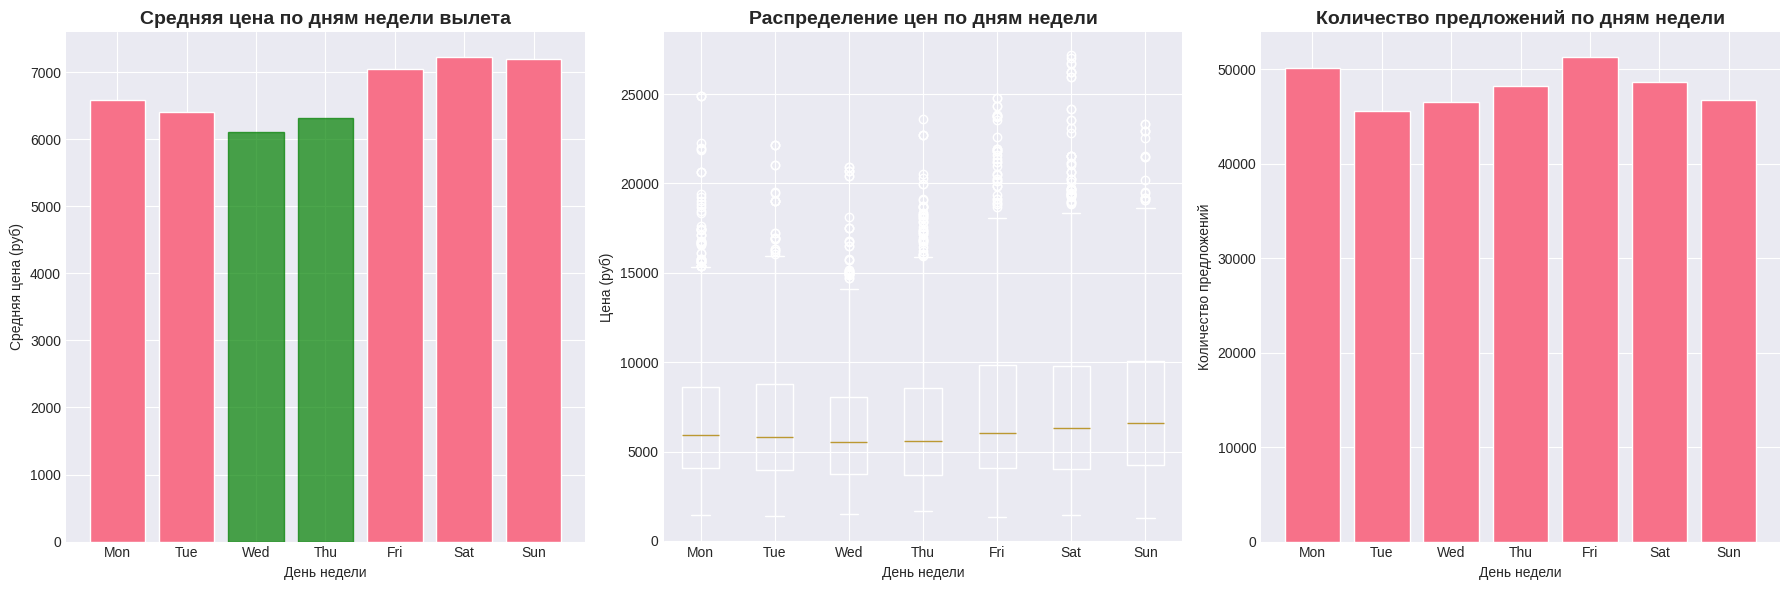


🎯 КЛЮЧЕВЫЕ ИНСАЙТЫ ПО ДНЯМ НЕДЕЛИ:
1. Лучший день для вылета: Wednesday (средняя цена: 6,114 руб)
2. Худший день для вылета: Saturday (средняя цена: 7,232 руб)
3. Экономия при выборе лучшего дня: 1,118 руб (15.5%)


In [39]:
def plot_weekday_analysis(df):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Порядок дней недели
    days_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    df['day_order'] = pd.Categorical(df['departure_weekday_short'], categories=days_order, ordered=True)
    df = df.sort_values('day_order')

    # 1. Средняя цена по дням недели
    ax1 = axes[0]
    bars = ax1.bar(range(len(df)), df['avg_price'])
    ax1.set_title('Средняя цена по дням недели вылета', fontsize=14, fontweight='bold')
    ax1.set_xlabel('День недели')
    ax1.set_ylabel('Средняя цена (руб)')
    ax1.set_xticks(range(len(df)))
    ax1.set_xticklabels(df['departure_weekday_short'])

    # Подсветка лучших дней
    best_days = df.nsmallest(2, 'avg_price')['departure_weekday_short'].values
    for i, bar in enumerate(bars):
        if df.iloc[i]['departure_weekday_short'] in best_days:
            bar.set_color('green')
            bar.set_alpha(0.7)

    # 2. Распределение цен (боксплот)
    ax2 = axes[1]

    # Получаем распределение цен по дням
    conn = get_db_connection()
    query_prices = """
    SELECT departure_weekday_short, price_rub
    FROM dm.dm_fact_ticket_offers
    WHERE departure_weekday_short IS NOT NULL
    LIMIT 10000
    """
    price_dist = pd.read_sql(query_prices, conn)
    conn.close()

    # Создаем боксплот
    price_dist['day_order'] = pd.Categorical(
        price_dist['departure_weekday_short'],
        categories=days_order,
        ordered=True
    )
    price_dist = price_dist.sort_values('day_order')

    box_data = [price_dist[price_dist['departure_weekday_short'] == day]['price_rub']
                for day in days_order if day in price_dist['departure_weekday_short'].unique()]

    ax2.boxplot(box_data, labels=days_order)
    ax2.set_title('Распределение цен по дням недели', fontsize=14, fontweight='bold')
    ax2.set_xlabel('День недели')
    ax2.set_ylabel('Цена (руб)')

    # 3. Количество предложений
    ax3 = axes[2]
    ax3.bar(range(len(df)), df['ticket_count'])
    ax3.set_title('Количество предложений по дням недели', fontsize=14, fontweight='bold')
    ax3.set_xlabel('День недели')
    ax3.set_ylabel('Количество предложений')
    ax3.set_xticks(range(len(df)))
    ax3.set_xticklabels(df['departure_weekday_short'])

    plt.tight_layout()
    plt.show()

    # Вывод инсайтов
    print("\n🎯 КЛЮЧЕВЫЕ ИНСАЙТЫ ПО ДНЯМ НЕДЕЛИ:")
    best_day = df.loc[df['avg_price'].idxmin()]
    worst_day = df.loc[df['avg_price'].idxmax()]
    print(f"1. Лучший день для вылета: {best_day['departure_weekday_full']} (средняя цена: {best_day['avg_price']:,.0f} руб)")
    print(f"2. Худший день для вылета: {worst_day['departure_weekday_full']} (средняя цена: {worst_day['avg_price']:,.0f} руб)")
    print(f"3. Экономия при выборе лучшего дня: {(worst_day['avg_price'] - best_day['avg_price']):,.0f} руб ({((worst_day['avg_price'] - best_day['avg_price'])/worst_day['avg_price']*100):.1f}%)")

plot_weekday_analysis(weekday_prices)

In [40]:
def analyze_days_before_departure():
    """Анализ цен в зависимости от дней до вылета"""
    conn = get_db_connection()
    query = """
    SELECT
        search_date,
        departure_date,
        (departure_date - search_date) as days_before_departure,
        price_rub,
        origin,
        destination
    FROM dm.dm_fact_ticket_offers
    WHERE departure_date IS NOT NULL
        AND search_date IS NOT NULL
        AND (departure_date - search_date) BETWEEN 0 AND 365
    LIMIT 10000
    """

    df_days = pd.read_sql(query, conn)
    conn.close()

    # Группируем по диапазонам дней
    bins = [0, 7, 14, 30, 60, 90, 180, 365]
    labels = ['0-7', '8-14', '15-30', '31-60', '61-90', '91-180', '181-365']
    df_days['days_range'] = pd.cut(df_days['days_before_departure'], bins=bins, labels=labels)

    return df_days

days_analysis = analyze_days_before_departure()

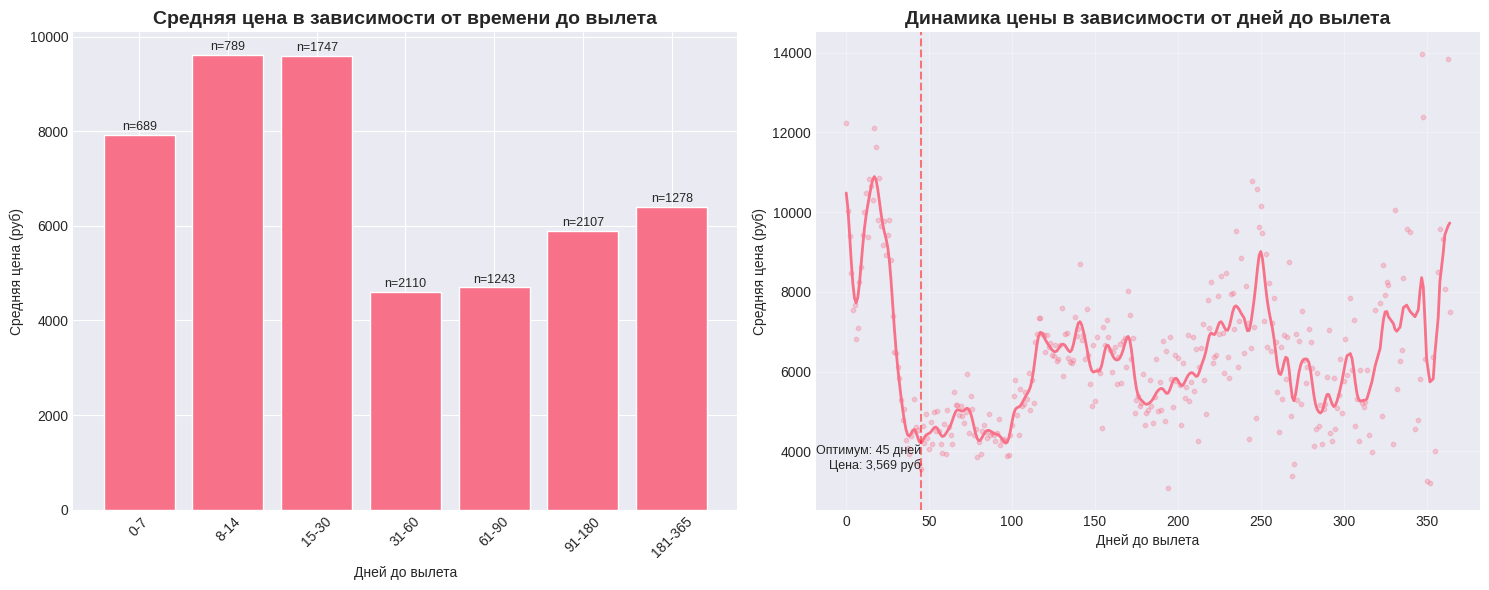


🎯 КЛЮЧЕВЫЕ ИНСАЙТЫ ПО ВРЕМЕНИ ПОКУПКИ:
1. Лучшее время для покупки: 31-60 дней до вылета
2. Худшее время для покупки: 8-14 дней до вылета
3. Рекомендация: покупать билеты за 30-60 дней до вылета


In [41]:
def plot_days_before_departure(df):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # 1. Средняя цена по диапазонам дней
    ax1 = axes[0]
    price_by_range = df.groupby('days_range')['price_rub'].agg(['mean', 'count', 'std']).reset_index()

    ax1.bar(range(len(price_by_range)), price_by_range['mean'])
    ax1.set_title('Средняя цена в зависимости от времени до вылета', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Дней до вылета')
    ax1.set_ylabel('Средняя цена (руб)')
    ax1.set_xticks(range(len(price_by_range)))
    ax1.set_xticklabels(price_by_range['days_range'], rotation=45)

    # Добавляем количество наблюдений
    for i, (idx, row) in enumerate(price_by_range.iterrows()):
        ax1.text(i, row['mean'] + 100, f"n={row['count']}", ha='center', fontsize=9)

    # 2. Линейный график средних цен
    ax2 = axes[1]

    # Группируем по точным дням (для больших групп)
    price_by_day = df.groupby('days_before_departure')['price_rub'].mean().reset_index()
    price_by_day = price_by_day.sort_values('days_before_departure')

    # Сглаживаем линию
    smoothed_prices = gaussian_filter1d(price_by_day['price_rub'], sigma=2)

    ax2.plot(price_by_day['days_before_departure'], smoothed_prices, linewidth=2)
    ax2.scatter(price_by_day['days_before_departure'], price_by_day['price_rub'], alpha=0.3, s=10)

    # Отмечаем оптимальное окно
    min_window_start = price_by_day.loc[price_by_day['days_before_departure'].between(30, 60)]
    if not min_window_start.empty:
        min_price_idx = min_window_start['price_rub'].idxmin()
        optimal_day = min_window_start.loc[min_price_idx]
        ax2.axvline(x=optimal_day['days_before_departure'], color='red', linestyle='--', alpha=0.5)
        ax2.text(optimal_day['days_before_departure'], optimal_day['price_rub'],
                f'Оптимум: {int(optimal_day["days_before_departure"])} дней\nЦена: {optimal_day["price_rub"]:,.0f} руб',
                fontsize=9, ha='right')

    ax2.set_title('Динамика цены в зависимости от дней до вылета', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Дней до вылета')
    ax2.set_ylabel('Средняя цена (руб)')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Вывод инсайтов
    print("\n🎯 КЛЮЧЕВЫЕ ИНСАЙТЫ ПО ВРЕМЕНИ ПОКУПКИ:")
    print(f"1. Лучшее время для покупки: {price_by_range.loc[price_by_range['mean'].idxmin()]['days_range']} дней до вылета")
    print(f"2. Худшее время для покупки: {price_by_range.loc[price_by_range['mean'].idxmax()]['days_range']} дней до вылета")
    print("3. Рекомендация: покупать билеты за 30-60 дней до вылета")

plot_days_before_departure(days_analysis)